# Signal quality assessment
In this tutorial we will assess the quality of MIMIC waveform signals.

Our **objectives** are to:
- Understand a template-matching approach to assess signal quality of cardiovascular signals.
- Apply the template-matching approach to ECG and PPG signals.
- Understand how to interpret the results.

<div class="alert alert-block alert-warning"><p><b>Context:</b> Physiological signals can be subject to noise from multiple sources. Signal quality assessment algorithms assess the quality of signals to determine whether they are of sufficient quality for a particular purpose (such as heart rate estimation). In this tutorial we will use the template-matching signal quality assessment algorithm described in <a href= https://doi.org/10.1109/JBHI.2014.2338351>this publication</a>.</p></div>

<div class="alert alert-block alert-info"><p><b>Extension:</b> If you want to find out more about photoplethysmography (PPG) signal quality assessment then I'd recommend <a href= https://doi.org/10.3390/app12199582>this publication</a>.</p></div>

## Setup

### Import packages

_The following steps have been covered in previous tutorials. We'll just re-use the previous code here._

In [ ]:
# Packages
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
!pip install wfdb==4.0.0
import wfdb

# import sys
# from pathlib import Path

### Import ECG beat detectors

In [ ]:
!pip install py-ecg-detectors

### Details of MIMIC record to use

Specify details of a MIMIC database record to use in this tutorial

In [102]:
# The name of the MIMIC IV Waveform Database on Physionet
database_name = 'mimic4wdb/0.1.0'

# Segment for analysis
segment_names = ['83404654_0005', '82924339_0007', '84248019_0005', '82439920_0004', '82800131_0002', '84304393_0001', '89464742_0001', '88958796_0004', '88995377_0001', '85230771_0004', '86643930_0004', '81250824_0005', '87706224_0003', '83058614_0005', '82803505_0017', '88574629_0001', '87867111_0012', '84560969_0001', '87562386_0001', '88685937_0001', '86120311_0001', '89866183_0014', '89068160_0002', '86380383_0001', '85078610_0008', '87702634_0007', '84686667_0002', '84802706_0002', '81811182_0004', '84421559_0005', '88221516_0007', '80057524_0005', '84209926_0018', '83959636_0010', '89989722_0016', '89225487_0007', '84391267_0001', '80889556_0002', '85250558_0011', '84567505_0005', '85814172_0007', '88884866_0005', '80497954_0012', '80666640_0014', '84939605_0004', '82141753_0018', '86874920_0014', '84505262_0010', '86288257_0001', '89699401_0001', '88537698_0013', '83958172_0001']
segment_dirs = ['mimic4wdb/0.1.0/waves/p100/p10020306/83404654', 'mimic4wdb/0.1.0/waves/p101/p10126957/82924339', 'mimic4wdb/0.1.0/waves/p102/p10209410/84248019', 'mimic4wdb/0.1.0/waves/p109/p10952189/82439920', 'mimic4wdb/0.1.0/waves/p111/p11109975/82800131', 'mimic4wdb/0.1.0/waves/p113/p11392990/84304393', 'mimic4wdb/0.1.0/waves/p121/p12168037/89464742', 'mimic4wdb/0.1.0/waves/p121/p12173569/88958796', 'mimic4wdb/0.1.0/waves/p121/p12188288/88995377', 'mimic4wdb/0.1.0/waves/p128/p12872596/85230771', 'mimic4wdb/0.1.0/waves/p129/p12933208/86643930', 'mimic4wdb/0.1.0/waves/p130/p13016481/81250824', 'mimic4wdb/0.1.0/waves/p132/p13240081/87706224', 'mimic4wdb/0.1.0/waves/p136/p13624686/83058614', 'mimic4wdb/0.1.0/waves/p137/p13791821/82803505', 'mimic4wdb/0.1.0/waves/p141/p14191565/88574629', 'mimic4wdb/0.1.0/waves/p142/p14285792/87867111', 'mimic4wdb/0.1.0/waves/p143/p14356077/84560969', 'mimic4wdb/0.1.0/waves/p143/p14363499/87562386', 'mimic4wdb/0.1.0/waves/p146/p14695840/88685937', 'mimic4wdb/0.1.0/waves/p149/p14931547/86120311', 'mimic4wdb/0.1.0/waves/p151/p15174162/89866183', 'mimic4wdb/0.1.0/waves/p153/p15312343/89068160', 'mimic4wdb/0.1.0/waves/p153/p15342703/86380383', 'mimic4wdb/0.1.0/waves/p155/p15552902/85078610', 'mimic4wdb/0.1.0/waves/p156/p15649186/87702634', 'mimic4wdb/0.1.0/waves/p158/p15857793/84686667', 'mimic4wdb/0.1.0/waves/p158/p15865327/84802706', 'mimic4wdb/0.1.0/waves/p158/p15896656/81811182', 'mimic4wdb/0.1.0/waves/p159/p15920699/84421559', 'mimic4wdb/0.1.0/waves/p160/p16034243/88221516', 'mimic4wdb/0.1.0/waves/p165/p16566444/80057524', 'mimic4wdb/0.1.0/waves/p166/p16644640/84209926', 'mimic4wdb/0.1.0/waves/p167/p16709726/83959636', 'mimic4wdb/0.1.0/waves/p167/p16715341/89989722', 'mimic4wdb/0.1.0/waves/p168/p16818396/89225487', 'mimic4wdb/0.1.0/waves/p170/p17032851/84391267', 'mimic4wdb/0.1.0/waves/p172/p17229504/80889556', 'mimic4wdb/0.1.0/waves/p173/p17301721/85250558', 'mimic4wdb/0.1.0/waves/p173/p17325001/84567505', 'mimic4wdb/0.1.0/waves/p174/p17490822/85814172', 'mimic4wdb/0.1.0/waves/p177/p17738824/88884866', 'mimic4wdb/0.1.0/waves/p177/p17744715/80497954', 'mimic4wdb/0.1.0/waves/p179/p17957832/80666640', 'mimic4wdb/0.1.0/waves/p180/p18080257/84939605', 'mimic4wdb/0.1.0/waves/p181/p18109577/82141753', 'mimic4wdb/0.1.0/waves/p183/p18324626/86874920', 'mimic4wdb/0.1.0/waves/p187/p18742074/84505262', 'mimic4wdb/0.1.0/waves/p188/p18824975/86288257', 'mimic4wdb/0.1.0/waves/p191/p19126489/89699401', 'mimic4wdb/0.1.0/waves/p193/p19313794/88537698', 'mimic4wdb/0.1.0/waves/p196/p19619764/83958172']

# Segment 0 is helpful for filtering, and 3 and 8 are helpful for differentiation
rel_segment_n = 0
rel_segment_name = segment_names[rel_segment_n]
rel_segment_dir = segment_dirs[rel_segment_n]

rel_segment_n = 8 
rel_segment_name = segment_names[rel_segment_n]
rel_segment_dir = segment_dirs[rel_segment_n]

### Signal quality assessment algorithm settings

Threshold to distinguish between high and low quality data.

In [103]:
thresh = 0.66 # For ECG, from: Orphanidou C et al., Signal-quality indices for the electrocardiogram and photoplethysmogram: derivation and applications to wireless monitoring. IEEE J Biomed Heal Informatics 2015;19:832–838. https://doi.org/10.1109/JBHI.2014.2338351

### Define template matching functions

- ```filter_ecg``` - normalises and applies a ~1-15 Hz Butterworth band-pass filter  

In [104]:
def filter_ecg(x, fs):
    sig = x
    # sig = sig[:,0]
    order = 3
    low_cutoff = 1  # in Hz
    high_cutoff = 15  # in Hz
    cutoff_frequency = (low_cutoff, high_cutoff)
    b, a = signal.butter(order, cutoff_frequency, btype='band', fs=fs)
    # b, a = signal.butter(3, [0.004, 0.06], 'band')    # original 
    sig = signal.filtfilt(b, a, sig, padlen=150)
    sig = (sig - min(sig)) / (max(sig) - min(sig))
    return sig

- ```detect_beats``` - detects beats in the ECG signal

In [105]:
from ecgdetectors import Detectors

def detect_beats(sig, fs):
    
    # detect beats
    detectors = Detectors(fs)
    #beats = detectors.swt_detector(sig)
    #beats = detectors.wqrs_detector(sig) 
    beats = detectors.hamilton_detector(sig)    
    
    # find R-peaks
    tol_secs = 0.15
    tol_samps = np.floor(fs*tol_secs)
    for beat_no in range(0,len(beats)-1):
            min_el = int(max([0, beats[beat_no]-tol_samps]))
            max_el = int(min([len(sig), beats[beat_no]+tol_samps]))
            curr_samps = sig[min_el:max_el+1]
            beats[beat_no] = int(beats[beat_no]-tol_samps+np.argmax(curr_samps))
    return beats

- ```find_rr_ints``` - finds RR intervals from beat indices

In [106]:
def find_rr_ints(beats,fs):
    
    rr_int = []
    for beat_no in range(0,len(beats)-1):
        rr_int.append((1/fs)*(beats[beat_no+1]-beats[beat_no]))   # in secs
    
    return rr_int

- ```assess_feasibility``` - assesses feasibility of beat detections

In [107]:
def assess_feasibility(beats):
    
    feas = 1
    
    # find HR
    hr = 60*len(beats)/((beats[-1]-beats[0])/fs)  # in bpm

    # check HR
    if hr < 40 or hr > 180:
        feas = 0
        
    # find RR intervals
    rr_int = find_rr_ints(beats,fs)   # in secs
        
    # check max RR interval
    if max(rr_int) > 3:
        feas = 0
    
    # check max to min RR interval
    rr_int_ratio = max(rr_int)/min(rr_int)
    if rr_int_ratio >= 2.2:
        feas = 0
    
    return feas

- ```calculate_med_rr_int``` - calculates the median RR interval (in samples)

In [108]:
def calculate_med_rr_int(beats):
    
    # find RR intervals
    rr_int = find_rr_ints(beats,1)   # in samples
    
    # find median RR interval
    med_rr_int = np.median(rr_int)
    
    return med_rr_int

- ```calculate_template``` - calculates a template beat shape

In [109]:
def calculate_template(sig, beats):
    
    # find median rr interval
    med_rr_int = calculate_med_rr_int(beats)
    
    # find no. samples either side of beat
    tol = int(np.floor(med_rr_int/2))
    sum_waves = np.zeros(1+2*tol)
    no_beats_used = 0
    for beat_no in range(0,len(beats)-1):
            min_el = beats[beat_no]-tol
            max_el = beats[beat_no]+tol
            if min_el < 0 or max_el > beats[-1]:
                continue
            curr_samps = sig[min_el:max_el+1]
            for i in range(0,len(sum_waves)):
                sum_waves[i] += curr_samps[i]
            no_beats_used +=1
    templ = sum_waves/no_beats_used
    return templ

- ```calculate_cc``` - calculates average correlation coefficient between template beat shape and individual beat shapes

In [110]:
def calculate_cc(sig, beats, templ):
    
    # find median rr interval
    med_rr_int = calculate_med_rr_int(beats)
    
    # find no. samples either side of beat
    tol = int(np.floor(med_rr_int/2))
    
    # calculate correlation coefficients for each beat
    sum_cc = 0
    no_beats_used = 0
    for beat_no in range(0,len(beats)-1):
            min_el = beats[beat_no]-tol
            max_el = beats[beat_no]+tol
            if min_el < 0 or max_el > beats[-1]:
                continue
            curr_samps = np.zeros(1+2*tol)
            for i in range(0, 1+2*tol):
                curr_samps[i] += sig[min_el+i]
            temp = np.corrcoef(curr_samps, templ)
            curr_cc = temp[0,1]
            sum_cc = np.add(sum_cc, curr_cc)
            no_beats_used +=1
            
    # find average correlation coefficient
    cc = sum_cc/no_beats_used
    return cc

- ```compare_cc_to_thresh``` - compares the average correlation coefficient to a threshold to determine whether the signal is of high or low quality

In [111]:
def compare_cc_to_thresh(cc, thresh):
    
    if cc >= thresh:
        qual = 1
    else:
        qual = 0
        
    return qual

- ```assess_qual``` - assesses the quality of a 10 second window of ECG signal

In [112]:
def assess_qual(x, fs, thresh):
    
    # filter ECG
    sig = filter_ecg(x, fs)
    
    # detect beats
    beats = detect_beats(sig, fs)
    
    # assess feasibility of beat detections
    feas = assess_feasibility(beats)
    if feas == 0:
        qual = 0
        return qual
    
    # create template beat shape
    templ = calculate_template(x, beats)
    
    # calculate correlation coefficient
    cc = calculate_cc(x, beats, templ)
    
    # compare correlation coefficient to threshold
    qual = compare_cc_to_thresh(cc, thresh)

    return qual


---
## Extract one minute of ECG and PPG signals from the MIMIC database

### Extract data

_These steps have been covered in previous tutorials, so we'll just re-use the code here._

In [113]:
# Specify the segment of data to be loaded
start_seconds = 20 # time since the start of the segment at which to begin extracting data
n_seconds_to_load = 60

# Load metadata for this record
segment_metadata = wfdb.rdheader(record_name=rel_segment_name, pn_dir=rel_segment_dir) 
fs = round(segment_metadata.fs)
print(f"Metadata loaded from segment: {rel_segment_name}")

# Load data from this record
sampfrom = fs*start_seconds
sampto = fs*(start_seconds + n_seconds_to_load)
segment_data = wfdb.rdrecord(record_name=rel_segment_name,
                             sampfrom=sampfrom,
                             sampto=sampto,
                             pn_dir=rel_segment_dir)
print(f"{n_seconds_to_load} seconds of data extracted from: {rel_segment_name}")

# Extract the PPG signal
sig_no = segment_data.sig_name.index('Pleth')
ppg = segment_data.p_signal[:,sig_no]
sig_no2 = segment_data.sig_name.index('II')
ecg = segment_data.p_signal[:,sig_no2]
fs = segment_data.fs
print(f"Extracted the PPG and ECG signals from columns {sig_no} and {sig_no2} of the matrix of waveform data.")

Metadata loaded from segment: 88995377_0001
60 seconds of data extracted from: 88995377_0001
Extracted the PPG and ECG signals from columns 4 and 2 of the matrix of waveform data.


### Plot data

Full duration of signal

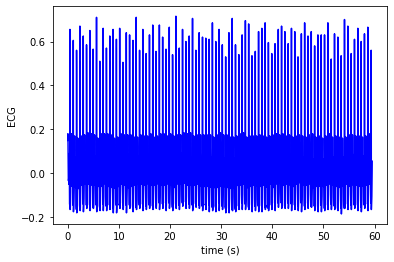

In [114]:
t = np.arange(0, (len(ecg) / fs), 1.0 / fs)
plt.plot(t, ecg, color = 'blue', label='ECG')
plt.xlabel('time (s)')
plt.ylabel('ECG')
plt.show()

Just a short segment

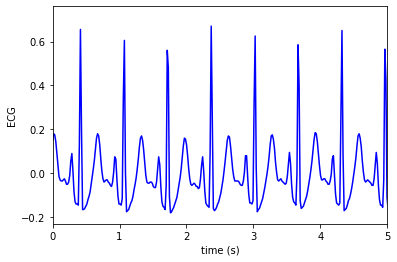

In [115]:
plt.plot(t, ecg, color = 'blue', label='ECG')
plt.xlabel('time (s)')
plt.ylabel('ECG')
plt.xlim(0,5)
plt.show()

---

## Assess signal quality of this sample data

Using the functions defined above:

### filter the ECG

In [116]:
sig = filter_ecg(ecg, fs)

Plot the result

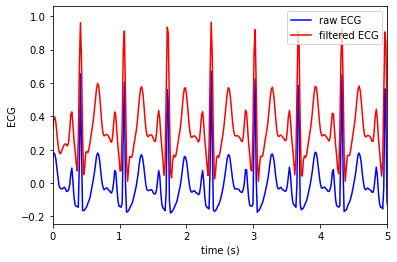

In [117]:
t = np.arange(0, (len(ecg) / fs), 1.0 / fs)
plt.plot(t, ecg, color = 'blue', label='raw ECG')
plt.plot(t, sig, color = 'red', label='filtered ECG')
plt.xlim([0, 5])
plt.xlabel('time (s)')
plt.ylabel('ECG')
plt.legend()
plt.show()

### detect beats

In [118]:
beats = detect_beats(sig, fs)

Plot the result

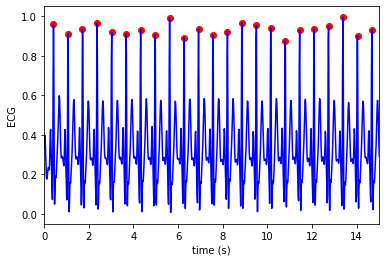

In [119]:
t = np.arange(0, (len(ecg) / fs), 1.0 / fs)
plt.plot(t, sig, color = 'blue', label='ECG')
plt.scatter(t[beats], sig[beats], color = 'red', marker = 'o', label='beats')
plt.xlim([0, 15])
plt.xlabel('time (s)')
plt.ylabel('ECG')
plt.show()

### assess feasibility of beat detections

In [120]:
feas = assess_feasibility(beats)
print(f'feas (1 indicates feasible): {feas}')

feas (1 indicates feasible): 1


### create template beat shape

In [121]:
templ = calculate_template(ecg, beats)

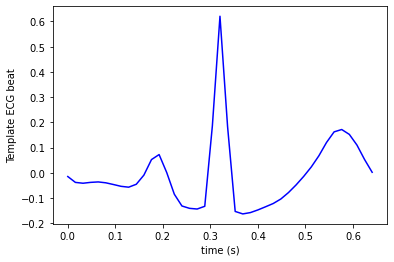

In [122]:
durn = (len(templ)-1)/fs
durn = durn+0.01
t = np.arange(0, durn, 1.0 / fs)
plt.plot(t, templ, color = 'blue', label='Template ECG beat')
plt.xlabel('time (s)')
plt.ylabel('Template ECG beat')
plt.show()

### calculate correlation coefficient

In [123]:
cc = calculate_cc(ecg, beats, templ)
print(f'Corr coeff: {cc}')

Corr coeff: 0.9606167664715456


### compare correlation coefficient to threshold

In [124]:
qual = compare_cc_to_thresh(cc, thresh)

if feas == 0:
        qual = 0
print(f'quality (1 indicates high quality): {qual}')

quality (1 indicates high quality): 1


<div class="alert alert-block alert-info"><p><b>Question:</b> What value of correlation coefficient would result in this being low quality?</p></div>

### Re-do quality assessment using single function

In [125]:
qual = assess_qual(ecg, fs, thresh)
print(f'quality (1 indicates high quality): {qual}')

quality (1 indicates high quality): 1


<div class="alert alert-block alert-info"><p><b>Extension 1:</b> How could we extend this to assess the quality of PPG signals? Consider what threshold would be required (see <a href="https://doi.org/10.1109/JBHI.2014.2338351">the original publication</a>) and how the code would need to be adjusted.</p></div>

<div class="alert alert-block alert-warning"><p><b>Further reading:</b> <a href="https://peterhcharlton.github.io/publication/ppg_sig_proc_chapter/">this book chapter</a> provides further information on PPG signal quality assessment.</p></div>